In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
from pathlib import Path

In [3]:
from bikesharing.ml_logic.data import get_raw_data ,get_weather_data ,get_polygons
from bikesharing.params import *

- Remove duplicates
- Deal with missing values
- Scale the features
- Encode features
- Perform cyclical engineering

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('./drive/MyDrive/Colab Notebooks/project')

In [ ]:
dfs = []
meta = {'years':[], 'n_columns':[], 'n_rows':[]}
for year in range(2019,2023,1):
    df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
    cols = [col.strip() for col in df.columns]
    df.columns = cols
    dfs.append(df)
    meta['years'].append(year)
    meta['n_columns'].append(df.shape[1])
    meta['n_rows'].append(df.shape[0])

/tmp/ipykernel_23698/1700516227.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_23698/1700516227.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_23698/1700516227.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')


In [ ]:
len(dfs)

4

In [ ]:
for df in dfs:
    print(df.shape)

(753678, 11)
(721752, 11)
(619573, 11)
(709144, 11)


In [ ]:
data = pd.concat(dfs, axis=0)

In [ ]:
def pre_process_df(df):
  #vstrip column names
  cols = [col.strip() for col in df.columns]
  df.columns = cols

  # remove column 'Row'
  if 'Row' in df.columns:
    df.drop(columns='Row', inplace=True)

  # select relevant columns only
  #df = df[['STARTTIME', 'STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']].copy()
  
  # make string replacements values
  df_obj = df.select_dtypes(include='object')
  df[df_obj.columns] = df_obj.applymap(lambda x: x.strip().replace(',', '.') if isinstance(x, str) else x)

  # handle datetime
  df.STARTTIME = pd.to_datetime(df.STARTTIME)

  # handle numeric columns
  df.replace('NULL', np.NAN, inplace=True)
  df.replace('', np.NAN, inplace=True)
  df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION','ENDLAT', 'ENDLON', 'RETURN_IS_STATION']] = df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION','ENDLAT', 'ENDLON', 'RETURN_IS_STATION']].astype(np.float32)
  
  return df

In [ ]:
data = pre_process_df(data)

In [ ]:
def load_data_to_bq(
        data: pd.DataFrame,
        gcp_project:str,
        bq_dataset:str,
        table: str,
        truncate: bool
    ) -> None:
    """
    - Save the DataFrame to BigQuery
    - Empty the table beforehand if `truncate` is True, append otherwise
    """

    assert isinstance(data, pd.DataFrame)
    full_table_name = f"{gcp_project}.{bq_dataset}.{table}"

    #print(Fore.BLUE + f"\nSave data to BigQuery @ {full_table_name}...:" + Style.RESET_ALL)


    # reset column names
    data.columns = [f'_{col}' if isinstance(col, int) else col for col in data.columns]

    # Load data onto full_table_name
    client = bigquery.Client()

    write_mode = "WRITE_TRUNCATE" if truncate else "WRITE_APPEND"
    job_config = bigquery.LoadJobConfig(write_disposition=write_mode)

    job = client.load_table_from_dataframe(data, full_table_name, job_config=job_config)

    # 🎯 HINT for "*** TypeError: expected bytes, int found":
    # After preprocessing the data, your original column names are gone (print it to check),
    # so ensure that your column names are *strings* that start with either
    # a *letter* or an *underscore*, as BQ does not accept anything else

    print(f"✅ Data saved to bigquery, with shape {data.shape}")


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2804147 entries, 0 to 709143
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   STARTTIME            datetime64[ns]
 1   ENDTIME              object        
 2   STARTLAT             float32       
 3   STARTLON             float32       
 4   ENDLAT               float32       
 5   ENDLON               float32       
 6   RENTAL_IS_STATION    float32       
 7   RENTAL_STATION_NAME  object        
 8   RETURN_IS_STATION    float32       
 9   RETURN_STATION_NAME  object        
dtypes: datetime64[ns](1), float32(6), object(3)
memory usage: 171.2+ MB


In [ ]:
load_data_to_bq(
        data=data,
        gcp_project=os.environ.get("GCP_PROJECT"),
        bq_dataset=os.environ.get("BQ_DATASET"),
        table='raw_data_mvg',
        truncate=True
    )

✅ Data saved to bigquery, with shape (2804147, 10)


In [31]:
query =f'''
        SELECT *
        FROM `{GCP_PROJECT}.{BQ_DATASET}.raw_data_mvg`
    '''

In [ ]:
data = get_raw_data(GCP_PROJECT, query=query, cache_path=Path(f'{LOCAL_DATA_PATH}/raw/MVG_Rad_Fahrten_{START_YEAR}_to_{END_YEAR}.csv'))
data

In [ ]:
import requests

base_url = 'https://archive-api.open-meteo.com/v1/archive'

params = {
    'latitude': 48.70,
    'longitude': 13.46,
    'start_date' : f'{START_YEAR}-01-01',
    'end_date' : f'{END_YEAR}-12-31',
    'hourly': ['temperature_2m', 'relativehumidity_2m', 'apparent_temperature','windspeed_10m','precipitation']
}

historical_weather_data = requests.get(base_url , params=params).json()

In [33]:
weather = get_weather_data(cache_path=Path(f'{LOCAL_DATA_PATH}/raw/Histotical_Weather_Data_{START_YEAR}_to_{END_YEAR}.csv'))
weather


Load weather_data from local CSV...
✅ Data loaded, with shape (35064, 6)


,time,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
0,2019-01-01T00:00,3.3,100,0.5,9.0,0.2
1,2019-01-01T01:00,3.4,99,0.4,9.7,0.1
2,2019-01-01T02:00,3.5,100,0.2,12.0,0.2
3,2019-01-01T03:00,3.5,99,0.0,13.5,0.1
4,2019-01-01T04:00,3.5,100,-0.0,14.1,0.0
...,...,...,...,...,...,...
35059,2022-12-31T19:00,6.5,83,3.9,8.0,0.0
35060,2022-12-31T20:00,5.9,83,3.4,6.8,0.0
35061,2022-12-31T21:00,5.8,81,3.1,7.2,0.0
35062,2022-12-31T22:00,6.1,78,3.1,8.8,0.0


In [100]:
weather.time = pd.to_datetime(weather.time)
weather['year'] = weather.time.apply(lambda x: x.year)
weather['month'] = weather.time.apply(lambda x: x.month)
weather['week'] = weather.time.apply(lambda x: x.week)
weather['day'] = weather.time.apply(lambda x: x.day)
weather['day_of_year'] = weather.time.apply(lambda x: x.day_of_year)


weather.head()

,time,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,year,month,week,day,day_of_year
0,2019-01-01 00:00:00,3.3,100,0.5,9.0,0.2,2019,1,1,1,1
1,2019-01-01 01:00:00,3.4,99,0.4,9.7,0.1,2019,1,1,1,1
2,2019-01-01 02:00:00,3.5,100,0.2,12.0,0.2,2019,1,1,1,1
3,2019-01-01 03:00:00,3.5,99,0.0,13.5,0.1,2019,1,1,1,1
4,2019-01-01 04:00:00,3.5,100,-0.0,14.1,0.0,2019,1,1,1,1


<Axes: >

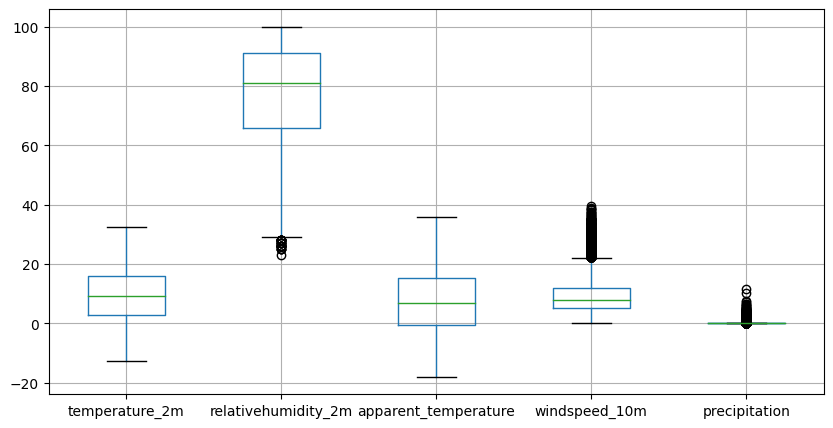

In [ ]:
df.boxplot(figsize=(10,5))

In [ ]:
dict = get_polygons()
dict

{'Maxvorstadt': <POLYGON ((11.539 48.143, 11.54 48.143, 11.542 48.143, 11.544 48.142, 11.545...>,
 'Schwabing-West': <POLYGON ((11.55 48.161, 11.55 48.161, 11.551 48.16, 11.551 48.16, 11.552 48...>,
 'Au - Haidhausen': <POLYGON ((11.569 48.122, 11.569 48.122, 11.569 48.122, 11.57 48.122, 11.57 ...>,
 'Sendling': <POLYGON ((11.535 48.13, 11.536 48.13, 11.536 48.13, 11.536 48.129, 11.536 4...>,
 'Schwanthalerhöhe': <POLYGON ((11.526 48.137, 11.526 48.137, 11.526 48.136, 11.526 48.136, 11.52...>,
 'Moosach': <POLYGON ((11.466 48.205, 11.466 48.204, 11.467 48.204, 11.468 48.204, 11.46...>,
 'Berg am Laim': <POLYGON ((11.601 48.124, 11.602 48.124, 11.604 48.123, 11.606 48.121, 11.60...>,
 'Trudering': <POLYGON ((11.644 48.115, 11.644 48.115, 11.646 48.114, 11.647 48.113, 11.64...>,
 'Ramersdorf': <POLYGON ((7.14 50.718, 7.143 50.718, 7.145 50.717, 7.147 50.717, 7.147 50.7...>,
 'Obergiesing': <POLYGON ((11.574 48.112, 11.574 48.112, 11.574 48.112, 11.574 48.112, 11.57...>,
 'Untergiesing': 

# RNN

## Lecture Code

In [4]:
from typing import Dict, List, Tuple, Sequence

def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    """
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """

    # TRAIN SET
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

def get_Xi_yi(
    fold:pd.DataFrame,
    input_length:int,
    output_length:int) -> Tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """

    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][TARGET]

    return (X_i, y_i)

def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int) -> Tuple[np.array]:
    """Given a fold generate X and y based on the number of desired sequences
    of the given input_length and output_length

    Args:
        fold (pd.DataFrame): Fold dataframe
        number_of_sequences (int): The number of X_i and y_i pairs to include
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)

def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, 
    sequence_stride: int) -> Tuple[np.array]:
    """slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence

    Args:
        fold (pd.DataFrame): One single fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        sequence_stride (int): How many timesteps to take before taking the next X_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][TARGET]
        X.append(X_i)
        y.append(y_i)

    return (np.array(X), np.array(y))


In [34]:
from bikesharing.interface.main import preprocess
from bikesharing.ml_logic.data import get_raw_data
from bikesharing.params import *

query =f'''
        SELECT *
        FROM `{GCP_PROJECT}.{BQ_DATASET}.raw_data_mvg`
    '''
df = get_raw_data(GCP_PROJECT, query=query, cache_path=Path(f'{LOCAL_DATA_PATH}/raw/mvg_rentals_from_{START_YEAR}_to_{END_YEAR}.csv'))




Load rental_data from local CSV...


/home/sandra/code/shoefer987/bike_sharing_demand/bikesharing/ml_logic/data.py:33: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cache_path, header='infer' if data_has_header else None)


✅ Data loaded, with shape (2804147, 10)


## Preprocessing

In [ ]:
from bikesharing.ml_logic.data import get_polygons, get_weather_data
from bikesharing.ml_logic.preprocessor import group_rental_data_by_hour, preprocess_features
from bikesharing.ml_logic.encoders import encode_district_label, encode_temporal_features
from bikesharing.ml_logic.feature_engineering import is_holiday, is_weekend, feature_selection

In [ ]:
# 2. drop cols
rental_relavent_cols_df = df[['STARTTIME' , 'STARTLAT' , 'STARTLON']]

# 3. clean(rm duplicates)
rental_relavent_cols_df = rental_relavent_cols_df.drop_duplicates()

# 4. encode y
encoded_rental_df = encode_district_label(rental_relavent_cols_df , get_polygons())

# 5. aggregate by hour
aggregated_rental_df = group_rental_data_by_hour(encoded_rental_df)

In [ ]:
aggregated_rental_df.to_csv(f'{LOCAL_DATA_PATH}/processed/aggregated_rental_df.csv', index=False)

In [36]:
aggregated_rental_df = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/aggregated_rental_df.csv')
aggregated_rental_df.rent_date_hour = pd.to_datetime(aggregated_rental_df.rent_date_hour)

In [37]:
# 6. join with weather data
weather_data_df = get_weather_data(cache_path=Path(f'{LOCAL_DATA_PATH}/raw/histotical_weather_data_{START_YEAR}_to_{END_YEAR}.csv'))
weather_data_df['time'] = pd.to_datetime(weather_data_df['time'])
merged_df = aggregated_rental_df.merge(weather_data_df, right_on='time' , left_on='rent_date_hour' , how='outer')
merged_df['rent_date_hour'] = merged_df['time']
merged_df = merged_df.sort_values(by='rent_date_hour').drop(columns=['time'])

# 7. feature enginering & merge
holidays = is_holiday(merged_df[['rent_date_hour']])
merged_df = merged_df.merge(holidays , on='rent_date_hour' , how='inner')

weekends = is_weekend(merged_df[['rent_date_hour']])
merged_df = merged_df.merge(weekends , on='rent_date_hour' , how='inner')

encoded_date = encode_temporal_features(merged_df[['rent_date_hour']])
merged_df = merged_df.merge(encoded_date , on='rent_date_hour' , how='inner')


Load weather_data from local CSV...
✅ Data loaded, with shape (35064, 6)


NameError: name 'is_holiday' is not defined

In [38]:
merged_df

,rent_date_hour,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,...,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
0,2019-01-01 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.3,100,0.5,9.0,0.2
1,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,3.4,99,0.4,9.7,0.1
2,2019-01-01 02:00:00,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,3.5,100,0.2,12.0,0.2
3,2019-01-01 03:00:00,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,3.5,99,0.0,13.5,0.1
4,2019-01-01 04:00:00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.5,100,-0.0,14.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34627,2022-12-31 19:00:00,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,6.5,83,3.9,8.0,0.0
34628,2022-12-31 20:00:00,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,5.9,83,3.4,6.8,0.0
34629,2022-12-31 21:00:00,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.8,81,3.1,7.2,0.0
34630,2022-12-31 22:00:00,5.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,6.1,78,3.1,8.8,0.0


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler

def preprocess_features(df: pd.DataFrame):

    df = df.fillna(0)
    def create_preprocessor() -> ColumnTransformer:

        # SCALE PIPE
        scaler_pipe = Pipeline([
            ('scaler', MinMaxScaler())
        ])

        return scaler_pipe

    X = df[['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation','hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]

    preprocessor = create_preprocessor()
    X_processed = preprocessor.fit_transform(X)

    return pd.concat([pd.DataFrame(X_processed) , df[['is_holiday', 'is_weekend']]] , axis=1)


In [ ]:
# 8. feature selection
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 'Berg am Laim', 'Bogenhausen',
       'Feldmoching', 'Hadern', 'Harlaching', 'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obermenzing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 'Untermenzing-Allach']

    
X = merged_df.drop(columns=districts)
y = merged_df[districts].fillna(0)

features = ['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'is_holiday', 'is_weekend',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']

selected_merged_df = feature_selection(X , features)

# 9. preproc-pipeline (Keep date_time for RNN)
X_processed = preprocess_features(selected_merged_df)

cache_path_X_preproc=Path(f'{LOCAL_DATA_PATH}/processed/X_processed_from_{START_YEAR}_to_{END_YEAR}.csv')
cache_path_y_preproc=Path(f'{LOCAL_DATA_PATH}/processed/y_processed_from_{START_YEAR}_to_{END_YEAR}.csv')

X_processed.columns = features
X_processed.to_csv(cache_path_X_preproc , header=True , index=False)
y.to_csv(cache_path_y_preproc , header=True , index=False)


In [111]:
merged_df['rentals_total'] = merged_df[districts].sum(axis=1)
merged_df['week'] = merged_df.rent_date_hour.apply(lambda x: x.week)
merged_df['month'] = merged_df.rent_date_hour.apply(lambda x: x.month)
merged_df['day'] = merged_df.rent_date_hour.apply(lambda x: x.day)
merged_df['day_of_year'] = merged_df.rent_date_hour.apply(lambda x: x.day_of_year)

In [59]:
weather.columns

Index(['time', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'year', 'month', 'week'],
      dtype='object')

In [112]:
merged_df.rentals_total

0         6.0
1        14.0
2        25.0
3        24.0
4        22.0
         ... 
34627    67.0
34628    28.0
34629    16.0
34630    29.0
34631    33.0
Name: rentals_total, Length: 35064, dtype: float64

<Axes: ylabel='rentals_total'>

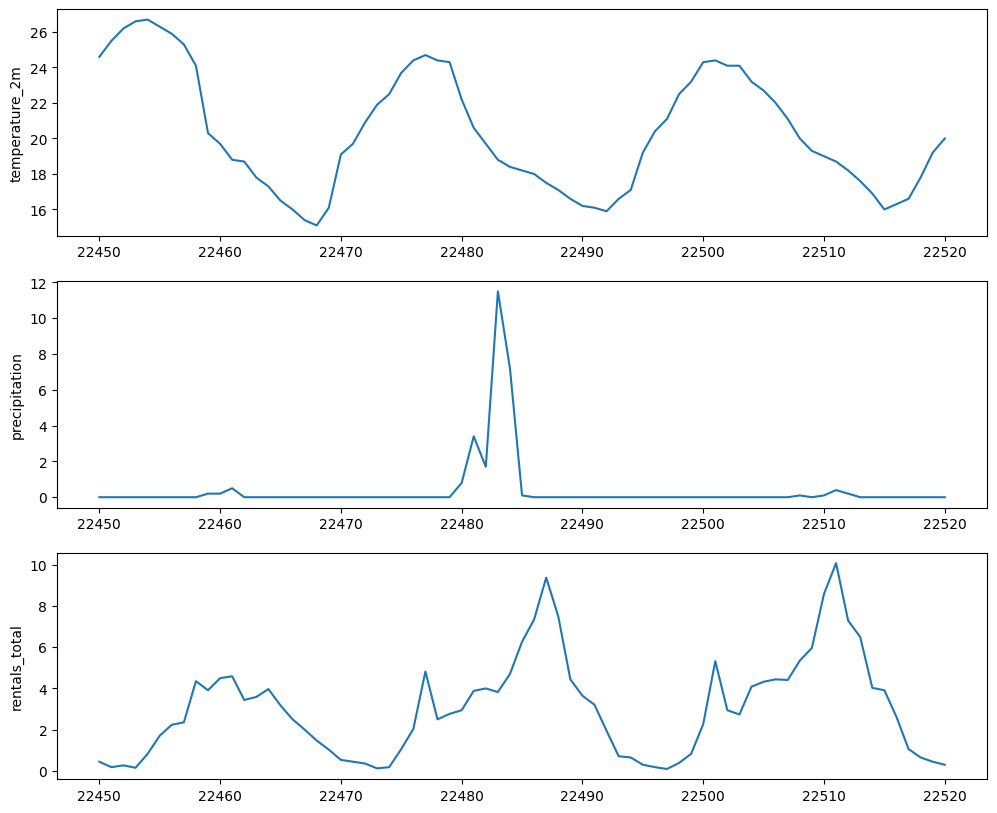

In [85]:
fig, ax = plt.subplots(3,1, figsize=(12,10))
sns.lineplot(x=weather.loc[22450:22520].index, y='temperature_2m', data=weather.loc[22450:22520], ax=ax[0], errorbar=('ci',0))
sns.lineplot(x=weather.loc[22450:22520].index, y='precipitation', data=weather.loc[22450:22520], ax=ax[1], errorbar=('ci', 0))
sns.lineplot(x=merged_df.loc[22450:22520].index, y='rentals_total', data=merged_df.loc[22450:22520], ax=ax[2], errorbar=('ci', 0))

<Axes: xlabel='week', ylabel='rentals_total'>

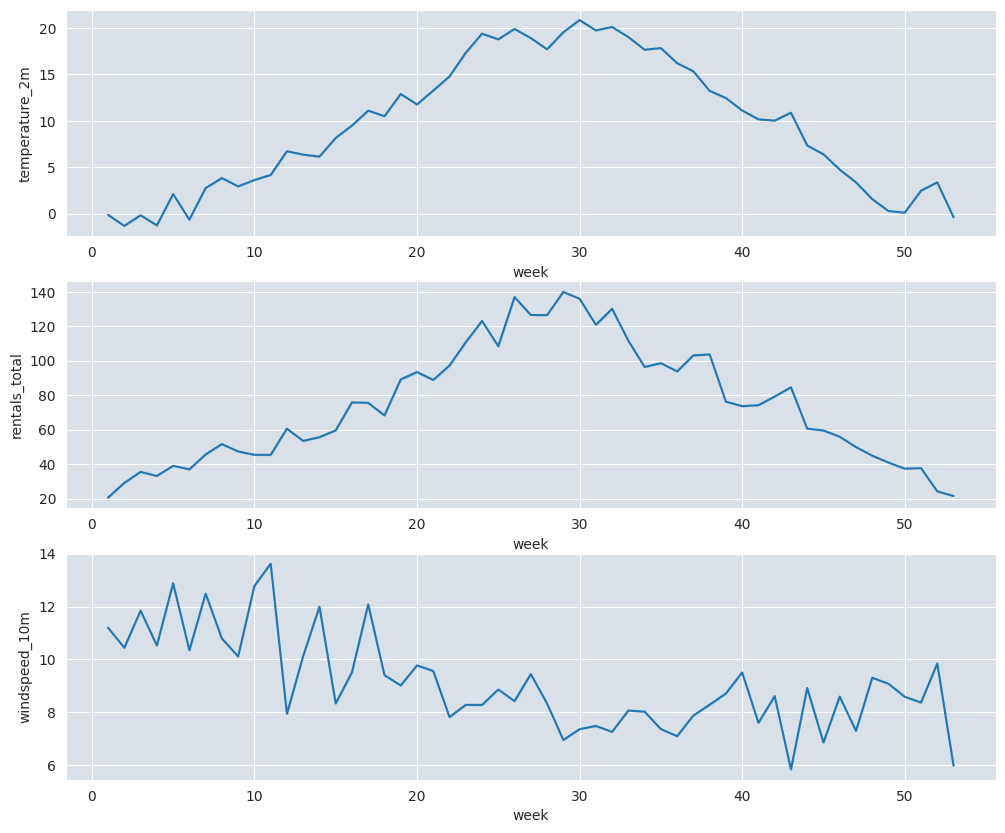

In [89]:
sns.set_style("darkgrid", {"axes.facecolor": (0, .2, .4, 0.15)})
fig, ax = plt.subplots(3,1, figsize=(12,10))
sns.lineplot(x='week', y='temperature_2m', data=weather, ax=ax[0], errorbar=('ci',0))
ax[0].set_title('Average Temperature per Week')
ax[0].set_ylabel('temperature (°C)')
sns.lineplot(x='week', y='windspeed_10m', data=weather, ax=ax[2], errorbar=('ci', 0))
ax[0].set_title('Average Temperature per Week')
ax[0].set_ylabel('rentals')

sns.lineplot(x='week', y='rentals_total', data=merged_df, ax=ax[1], errorbar=('ci', 0))

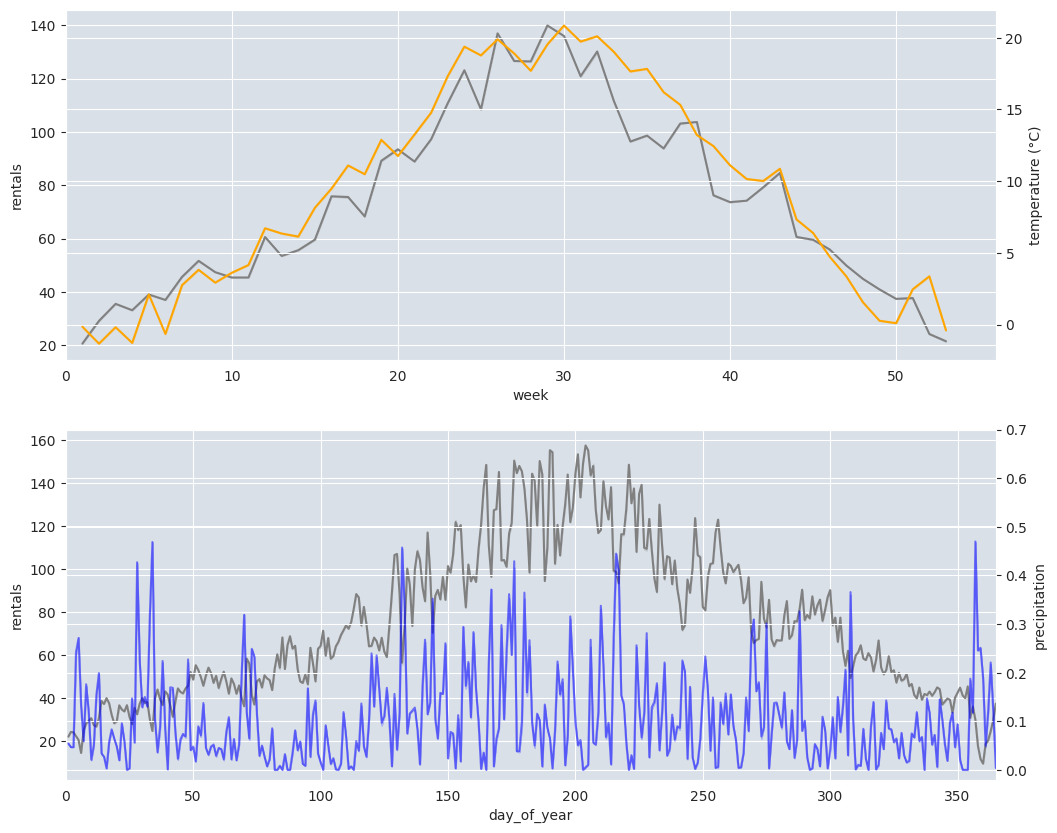

In [116]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
sns.lineplot(x='week', y='rentals_total', data=merged_df, ax=ax[0], errorbar=('ci',0), color='grey')
ax[0].set_ylabel('rentals')
ax[0].set_xlim(0,56)
ax2 = ax[0].twinx()
sns.lineplot(x='week', y='temperature_2m', data=weather, ax=ax2, errorbar=('ci', 0), color='orange')
ax2.set_ylabel('temperature (°C)')

sns.lineplot(x='day_of_year', y='rentals_total', data=merged_df, ax=ax[1], errorbar=('ci',0), color='grey')
ax[1].set_ylabel('rentals')
ax[1].set_xlim(0,365)
ax3 = ax[1].twinx()
sns.lineplot(x='day_of_year', y='precipitation', data=weather, ax=ax3, errorbar=('ci', 0), color='blue', alpha=0.5)
ax3.set_ylabel('precipitation')
ax3.set_ylim(-0.02,0.7);

In [ ]:
X_processed.head()

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,is_holiday,is_weekend,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
0,0.355408,1.000000,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1,0
1,0.357616,0.987013,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1,0
2,0.359823,1.000000,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1,0
3,0.359823,0.987013,0.332714,0.341772,0.008696,0.933013,0.750000,0.75,0.933013,0.600779,0.989739,1,0
4,0.359823,1.000000,0.332714,0.356962,0.000000,0.982963,0.629410,0.75,0.933013,0.600779,0.989739,1,0


In [ ]:
X_hd = X_processed.loc[:X_processed.shape[0] * 0.75]
X_hd.shape

(26299, 13)

In [ ]:
pd.DataFrame(y.describe().loc['mean']).sort_values(by='mean', ascending=False)

,mean
Maxvorstadt,10.995209
Ludwigsvorstadt-Isarvorstadt,7.500371
Schwabing-Freimann,7.117328
Altstadt-Lehel,6.599390
Neuhausen-Nymphenburg,6.161733
Schwabing-West,5.402749
Milbertshofen-Am Hart,3.849047
Au - Haidhausen,3.466205
Sendling,3.101044
Bogenhausen,2.344484


In [ ]:
drop_cols = ['Aubing-Lochhausen-Langwied', 'Harlaching', 'Südgiesing', 'Hasenbergl-Lerchenau Ost', 'Obermenzing', 'Feldmoching', 
             'Untermenzing-Allach', 'Lochhausen']

In [ ]:
y.drop(columns=drop_cols, inplace=True)
y.shape

(35064, 26)

In [ ]:
y_hd = y.loc[:y.shape[0] * 0.75]
y_hd.shape

(26299, 26)

## Sampling

In [ ]:
data = pd.concat([X_hd, y_hd], axis=1)
data.shape

(26299, 39)

In [ ]:
districts = y.columns
districts

In [ ]:
data.to_csv(f'{LOCAL_DATA_PATH}/processed/data_for_rnn_subset_of_districts.csv', index=False)

In [5]:
data = pd.read_csv('./data_for_rnn.csv')
data.shape

(26299, 47)

In [6]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen', 
       'Berg am Laim', 'Bogenhausen', 'Hadern', 'Laim', 
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Aubing-Lochhausen-Langwied', 'Harlaching', 'Südgiesing', 'Hasenbergl-Lerchenau Ost', 
       'Obermenzing', 'Feldmoching', 'Untermenzing-Allach', 'Lochhausen']

In [7]:
FOLD_LENGTH = 17520
FOLD_STRIDE = 2184
TRAIN_TEST_RATIO = 0.8
INPUT_LENGTH = 672 # 24 h * 28 d
OUTPUT_LENGTH = 24
SEQUENCE_STRIDE = 1

In [9]:
folds = get_folds(data, FOLD_LENGTH, FOLD_STRIDE)
print(f'number of folds: {len(folds)}')

number of folds: 5


In [10]:
(fold_train, fold_test) = train_test_split(folds[0], TRAIN_TEST_RATIO, INPUT_LENGTH)

In [8]:
(fold_train, fold_test) = train_test_split(data, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [9]:
TARGET = districts
N_TARGETS = len(districts)
N_FEATURES = 13

In [12]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [13]:
X_train_i

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,is_holiday,is_weekend,hour_sin,hour_cos,month_sin,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
9997,0.403974,0.363636,0.319703,0.617722,0.0,0.250000,0.066987,0.933013,0.75,0.050521,...,4.0,4.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0
9998,0.410596,0.272727,0.328996,0.559494,0.0,0.146447,0.146447,0.933013,0.75,0.050521,...,3.0,4.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
9999,0.408389,0.259740,0.327138,0.551899,0.0,0.066987,0.250000,0.933013,0.75,0.050521,...,4.0,4.0,3.0,0.0,0.0,3.0,3.0,1.0,1.0,0.0
10000,0.392936,0.311688,0.330855,0.407595,0.0,0.017037,0.370590,0.933013,0.75,0.050521,...,3.0,5.0,3.0,0.0,1.0,3.0,3.0,1.0,1.0,0.0
10001,0.368653,0.363636,0.321561,0.291139,0.0,0.000000,0.500000,0.933013,0.75,0.050521,...,3.0,2.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10664,0.549669,0.623377,0.533457,0.088608,0.0,0.853553,0.146447,1.000000,0.50,0.104104,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0
10665,0.589404,0.506494,0.565056,0.116456,0.0,0.750000,0.066987,1.000000,0.50,0.104104,...,3.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
10666,0.613687,0.454545,0.589219,0.086076,0.0,0.629410,0.017037,1.000000,0.50,0.104104,...,2.0,5.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
10667,0.637969,0.415584,0.622677,0.063291,0.0,0.500000,0.000000,1.000000,0.50,0.104104,...,0.0,4.0,3.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0


### Random Sampling

In [25]:
N_TRAIN = 8000 # number_of_sequences_train
N_TEST =  2000 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

### Chronological Sampling

In [10]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

In [11]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (20343, 672, 47), y_train: (20343, 24, 34)
X_test: (5236, 672, 47), y_test: (5236, 24, 34)


In [16]:
X_train[0,0,:]

array([0.35540839, 1.        , 0.34200743, 0.2278481 , 0.0173913 ,
       0.62940952, 0.98296291, 0.75      , 0.9330127 , 0.60077861,
       0.98973865, 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.        , 0.        , 0.        , 2.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [17]:
y_train[0,0,:]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Modelling

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [12]:
def init_model(X_train, y_train):
    # E1D1
    # n_features ==> no of features at each timestep in the data.
    #
    encoder_inputs = layers.Input(shape=X_train[0].shape)

    norm_layer = layers.Normalization()
    norm_layer.adapt(X_train)
    norm = norm_layer(encoder_inputs)

    encoder_l1 = layers.LSTM(100, return_state=True)
    encoder_outputs1 = encoder_l1(norm)

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = layers.RepeatVector(OUTPUT_LENGTH)(encoder_outputs1[0])

    #
    decoder_l1 = layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = layers.TimeDistributed(layers.Dense(y_train[0].shape[1]))(decoder_l1)

    #
    model_e1d1 = models.Model(encoder_inputs,decoder_outputs1)
    
    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model_e1d1.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model_e1d1


In [13]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [14]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

def fit_model(model: keras.Model, verbose=1) -> Tuple[keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = False)

    return model, history

In [ ]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

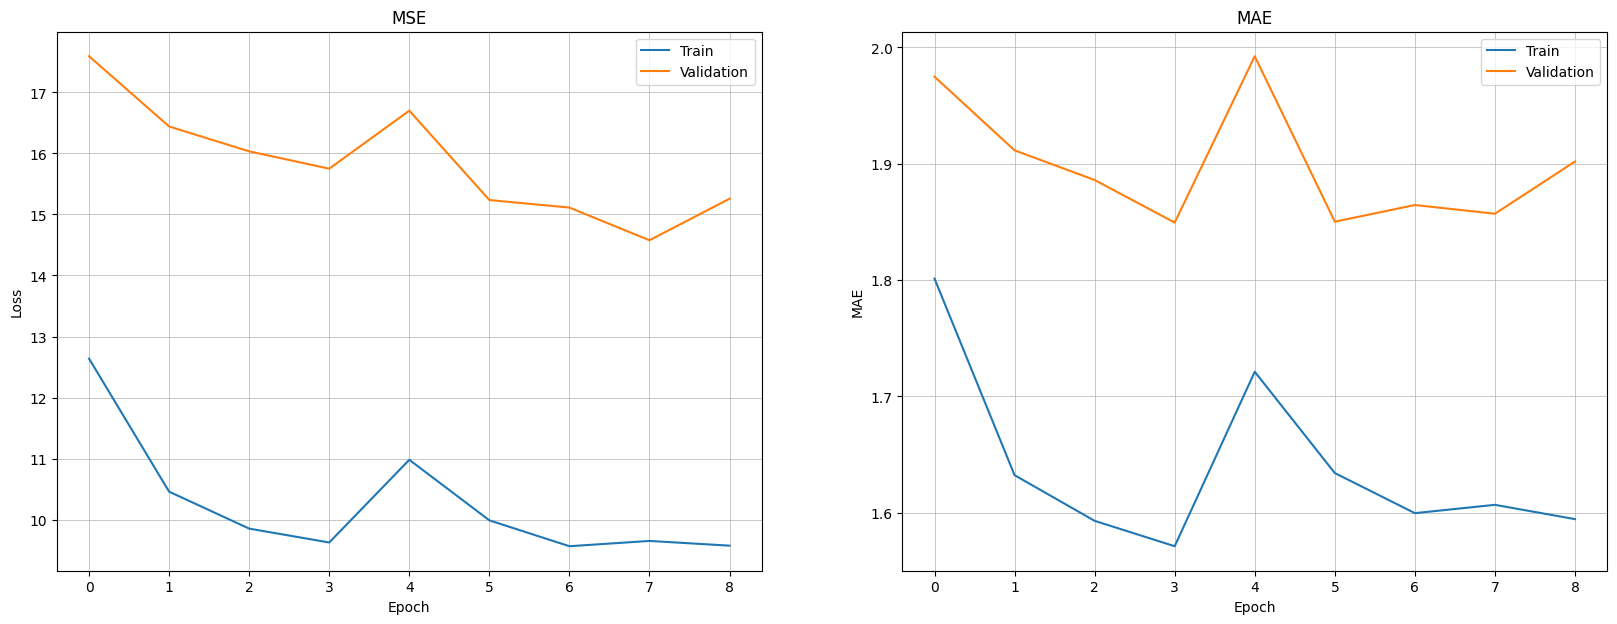

In [25]:
plot_history(history)

In [ ]:
np.sqrt(5.5)

2.345207879911715

In [ ]:
model.save('./models/2023-06-11_14:15_rnn_subset_of_districts')

In [ ]:
model = models.load_model('./models/2023-06-09_14:30_rnn_normalized')

## Cross-Validation

In [16]:
def cross_validate_baseline_and_lstm(data: pd.DataFrame):
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    #list_of_mae_baseline_model = []
    list_of_mse_recurrent_model = []
    hist = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(data, FOLD_LENGTH, FOLD_STRIDE)
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)                   

        X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        #X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        #X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        #baseline_model = init_baseline()
        #mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        #list_of_mae_baseline_model.append(mae_baseline)
        #print("-"*50)
        #print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "loss",
                           mode = "min",
                           patience = 5, 
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        hist.append(history)
        res = model.evaluate(X_test, y_test, verbose=0)
        mse_lstm = res[1]
        list_of_mse_recurrent_model.append(mse_lstm)
        print(f"MSE LSTM fold n°{fold_id} = {round(mse_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        #print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    #return list_of_mae_baseline_model, list_of_mae_recurrent_model
    return list_of_mse_recurrent_model, hist

In [ ]:
mses, histories = cross_validate_baseline_and_lstm(data)

MSE LSTM fold n°0 = 14.09
MSE LSTM fold n°1 = 4.8
MSE LSTM fold n°2 = 20.2
MSE LSTM fold n°3 = 17.93


In [ ]:
mses

## Evaluation

In [ ]:
data_eval = pd.read_csv('./eval_data_for_rnn.csv')
data_eval.head()

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,is_holiday,is_weekend,hour_sin,hour_cos,month_sin,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,0.421634,0.909091,0.397770,0.288608,0.0,0.066987,0.750000,0.5,1.0,0.5,...,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.419426,0.870130,0.388476,0.339241,0.0,0.146447,0.853553,0.5,1.0,0.5,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.419426,0.857143,0.379182,0.410127,0.0,0.250000,0.933013,0.5,1.0,0.5,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.417219,0.857143,0.386617,0.334177,0.0,0.370590,0.982963,0.5,1.0,0.5,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.415011,0.870130,0.382900,0.356962,0.0,0.500000,1.000000,0.5,1.0,0.5,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
drop_cols = ['Aubing-Lochhausen-Langwied', 'Harlaching', 'Südgiesing', 'Hasenbergl-Lerchenau Ost', 'Obermenzing', 'Feldmoching', 
             'Untermenzing-Allach', 'Lochhausen']

In [ ]:
data_eval.drop(columns=drop_cols, inplace=True)
data_eval.columns

Index(['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'is_holiday', 'is_weekend',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'Altstadt-Lehel', 'Au - Haidhausen', 'Berg am Laim', 'Bogenhausen',
       'Hadern', 'Laim', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obersendling', 'Pasing', 'Pasing-Obermenzing',
       'Ramersdorf-Perlach', 'Schwabing-Freimann', 'Schwabing-West',
       'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark', 'Thalkirchen',
       'Trudering', 'Trudering-Riem', 'Untergiesing',
       'Untergiesing-Harlaching'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(data[districts])
data_eval_scaled = data_eval.copy()
data_eval_scaled[districts] = scaler.transform(data_eval[districts])
data_eval_scaled.head()

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,is_holiday,is_weekend,hour_sin,hour_cos,month_sin,...,Schwabing-Freimann,Schwabing-West,Schwanthalerhöhe,Sendling,Sendling-Westpark,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching
0,0.421634,0.909091,0.397770,0.288608,0.0,0.066987,0.750000,0.5,1.0,0.5,...,-0.469442,0.481129,0.022526,-0.515992,0.678459,-0.474534,-0.456445,-0.456445,-0.711432,-0.711432
1,0.419426,0.870130,0.388476,0.339241,0.0,0.146447,0.853553,0.5,1.0,0.5,...,-0.801573,-0.942260,-0.383520,-0.256610,-0.722991,-0.474534,-0.456445,-0.456445,-0.711432,-0.711432
2,0.419426,0.857143,0.379182,0.410127,0.0,0.250000,0.933013,0.5,1.0,0.5,...,-0.801573,-0.408489,0.022526,-0.256610,-0.255841,-0.474534,-0.456445,-0.456445,-0.711432,-0.711432
3,0.417219,0.857143,0.386617,0.334177,0.0,0.370590,0.982963,0.5,1.0,0.5,...,-0.690863,-0.942260,0.022526,-0.775373,-0.722991,-0.474534,-0.456445,-0.456445,-0.711432,-0.711432
4,0.415011,0.870130,0.382900,0.356962,0.0,0.500000,1.000000,0.5,1.0,0.5,...,-0.801573,-0.764336,-0.383520,-0.515992,-0.722991,-0.474534,-0.456445,-0.456445,-0.711432,-0.711432


In [ ]:
# create sequences of X and y_true for evaluation 
X_eval, y_true = [], []

for i in range(0,len(data_eval)-INPUT_LENGTH-OUTPUT_LENGTH,OUTPUT_LENGTH):
    Xi = data_eval_scaled.loc[i:i+INPUT_LENGTH-1]
    yi = data_eval[i+INPUT_LENGTH:i+INPUT_LENGTH+OUTPUT_LENGTH][districts]
    X_eval.append(Xi.to_numpy())
    y_true.append(yi.to_numpy())


In [ ]:
X_eval = np.array(X_eval)
y_true = np.array(y_true)
print(f'X_eval: {X_eval.shape}, y_true: {y_true.shape}')

X_eval: (337, 672, 39), y_true: (337, 24, 26)


In [ ]:
  X_eval[0,0,:]

array([ 0.42163355,  0.90909091,  0.39776952,  0.28860759,  0.        ,
        0.0669873 ,  0.75      ,  0.5       ,  1.        ,  0.5       ,
        1.        ,  0.        ,  0.        , -0.16360677, -0.34312331,
       -0.10190387, -0.77566961, -0.56795358, -0.29169814, -0.15446401,
       -0.32931341, -0.1711084 , -0.37135425, -0.00839788, -0.2435137 ,
       -0.41986766, -0.49323141, -0.55302767, -0.70463355, -0.46944221,
        0.48112927,  0.02252639, -0.51599157,  0.6784589 , -0.47453424,
       -0.45644516, -0.45644516, -0.71143153, -0.71143153])

### Evaluation Score

In [ ]:
model.evaluate(X_eval, y_true)

11/11 [==============================] - 1s 33ms/step - loss: 17.5079 - mae: 2.1037


[17.507869720458984, 2.10367488861084]

In [ ]:
np.sqrt(17.5079)

4.18424425673263

In [ ]:
y_pred = model.predict(X_eval)
y_pred.shape

11/11 [==============================] - 0s 20ms/step


(337, 24, 34)

In [ ]:
y_df = []
for i in range(y_pred.shape[0]):
  y_df.append(pd.DataFrame(y_pred[i], columns=districts))

In [ ]:
y_pred_total = pd.concat(y_df, axis=0).reset_index().drop(columns='index')
y_pred_total.shape

(8088, 34)

In [ ]:
y_true_total = data_eval[INPUT_LENGTH:-5][districts].reset_index().drop(columns='index')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

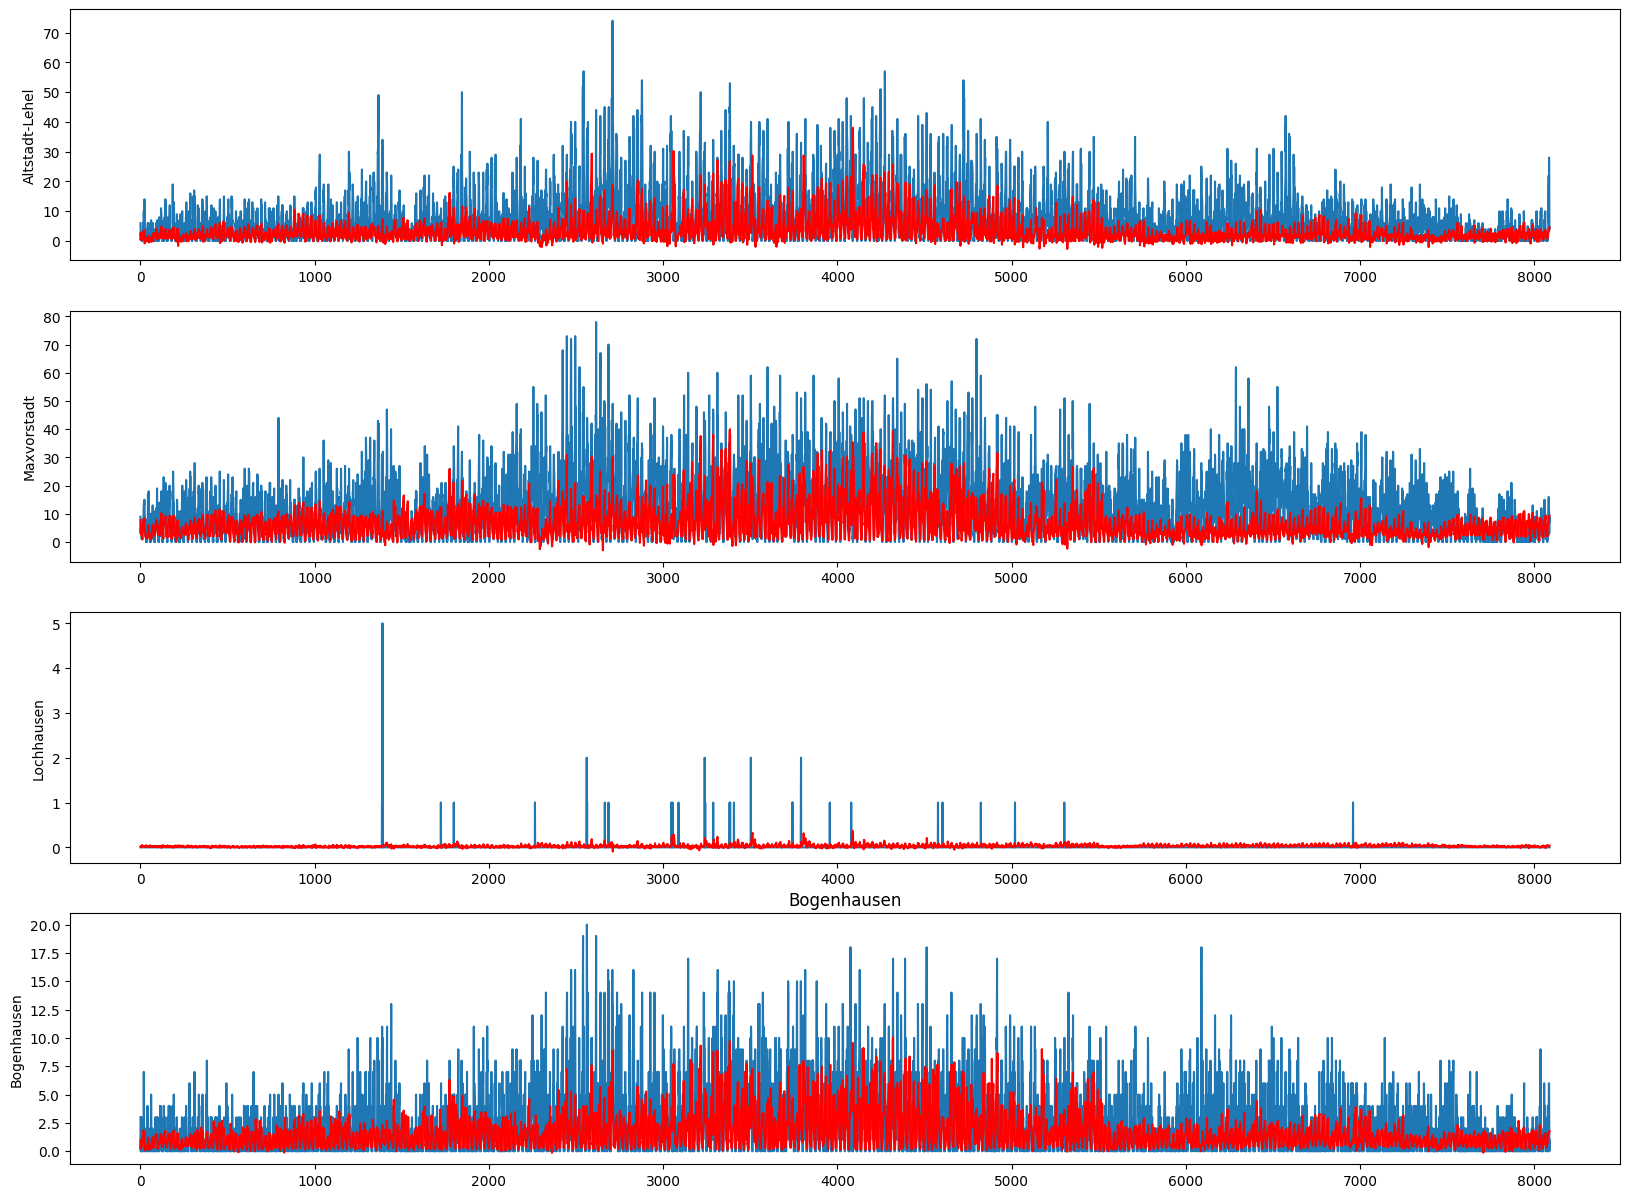

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(20,15))
districts=['Altstadt-Lehel', 'Maxvorstadt', 'Lochhausen', 'Bogenhausen']
for i in range(4):
  sns.lineplot(x=y_true_total.index, y=districts[i], data=y_true_total, ax=ax[i])
  sns.lineplot(x=y_pred_total.index, y=districts[i], data=y_pred_total, ax=ax[i], color='red')
  plt.title(districts[i]);

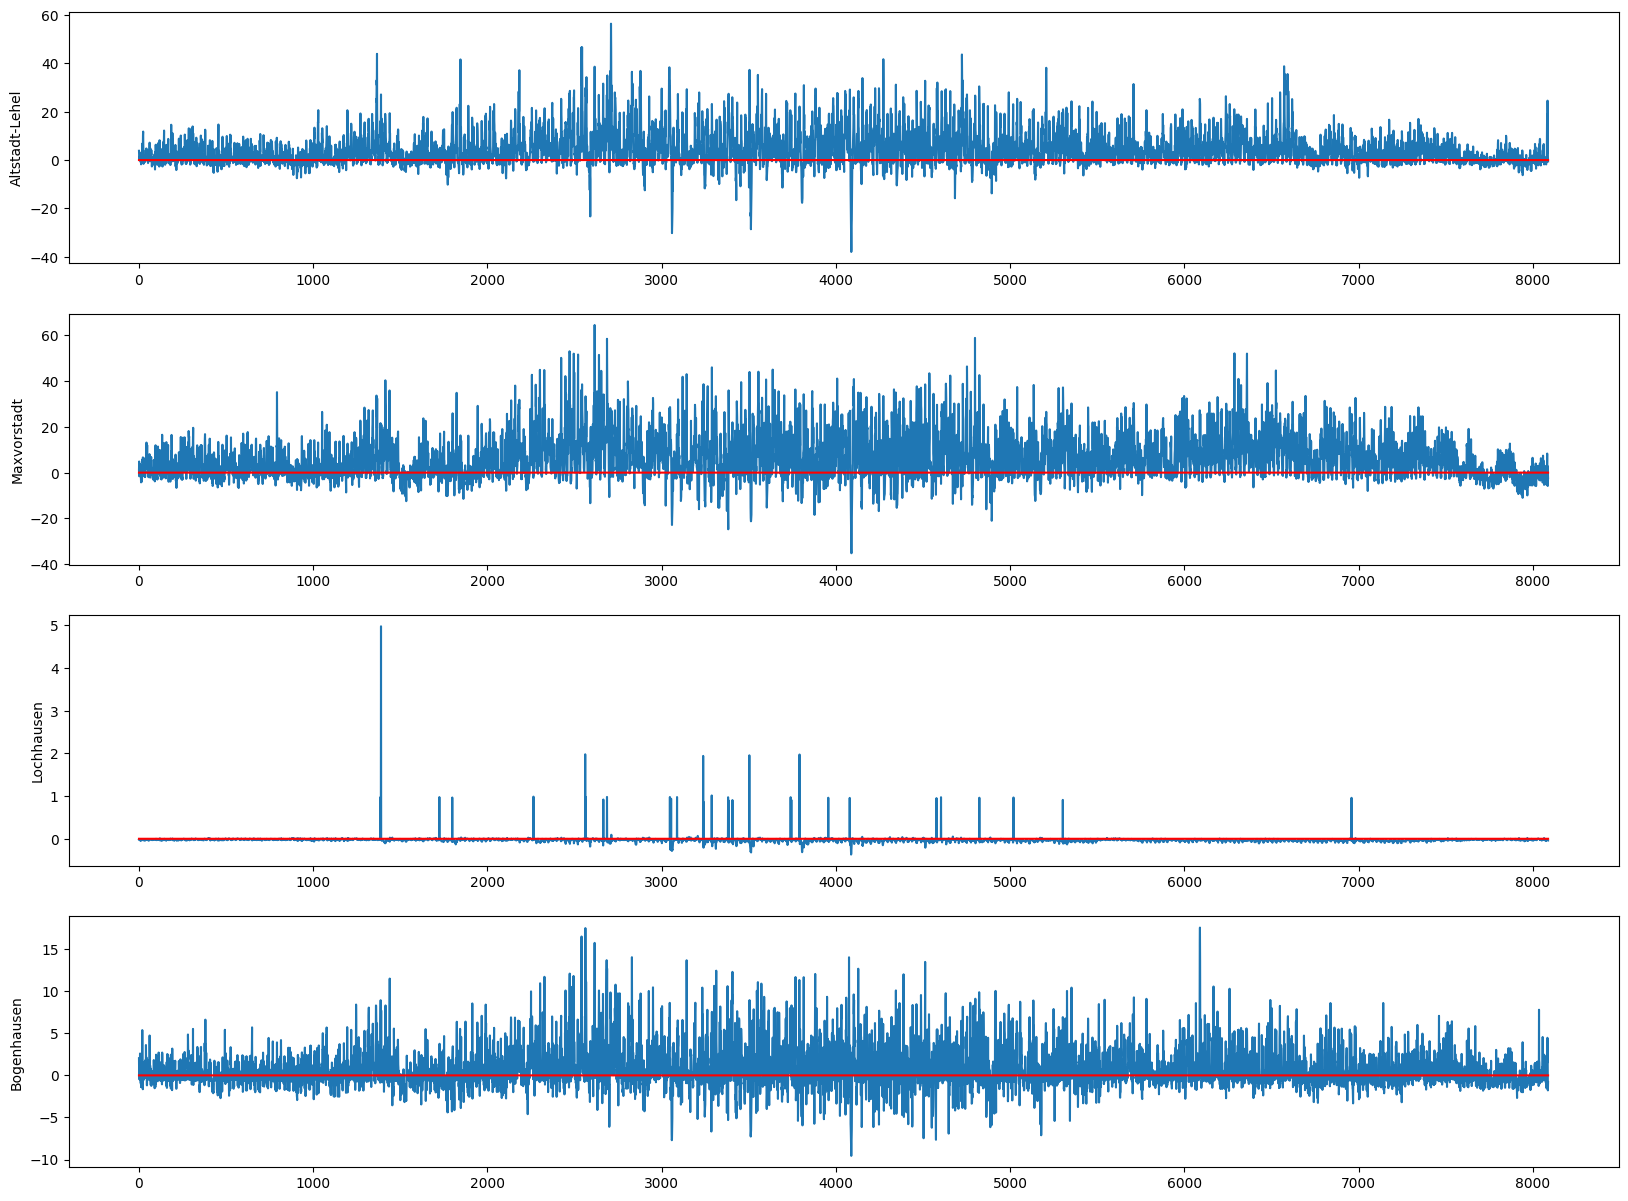

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(20,15))
for i in range(4):
  residuals = y_true_total[[districts[i]]] - y_pred_total[[districts[i]]]
  sns.lineplot(x=residuals.index, y=districts[i], data=residuals, ax=ax[i])
  sns.lineplot(x=residuals.index, y=0, data=residuals, ax=ax[i], color='red');

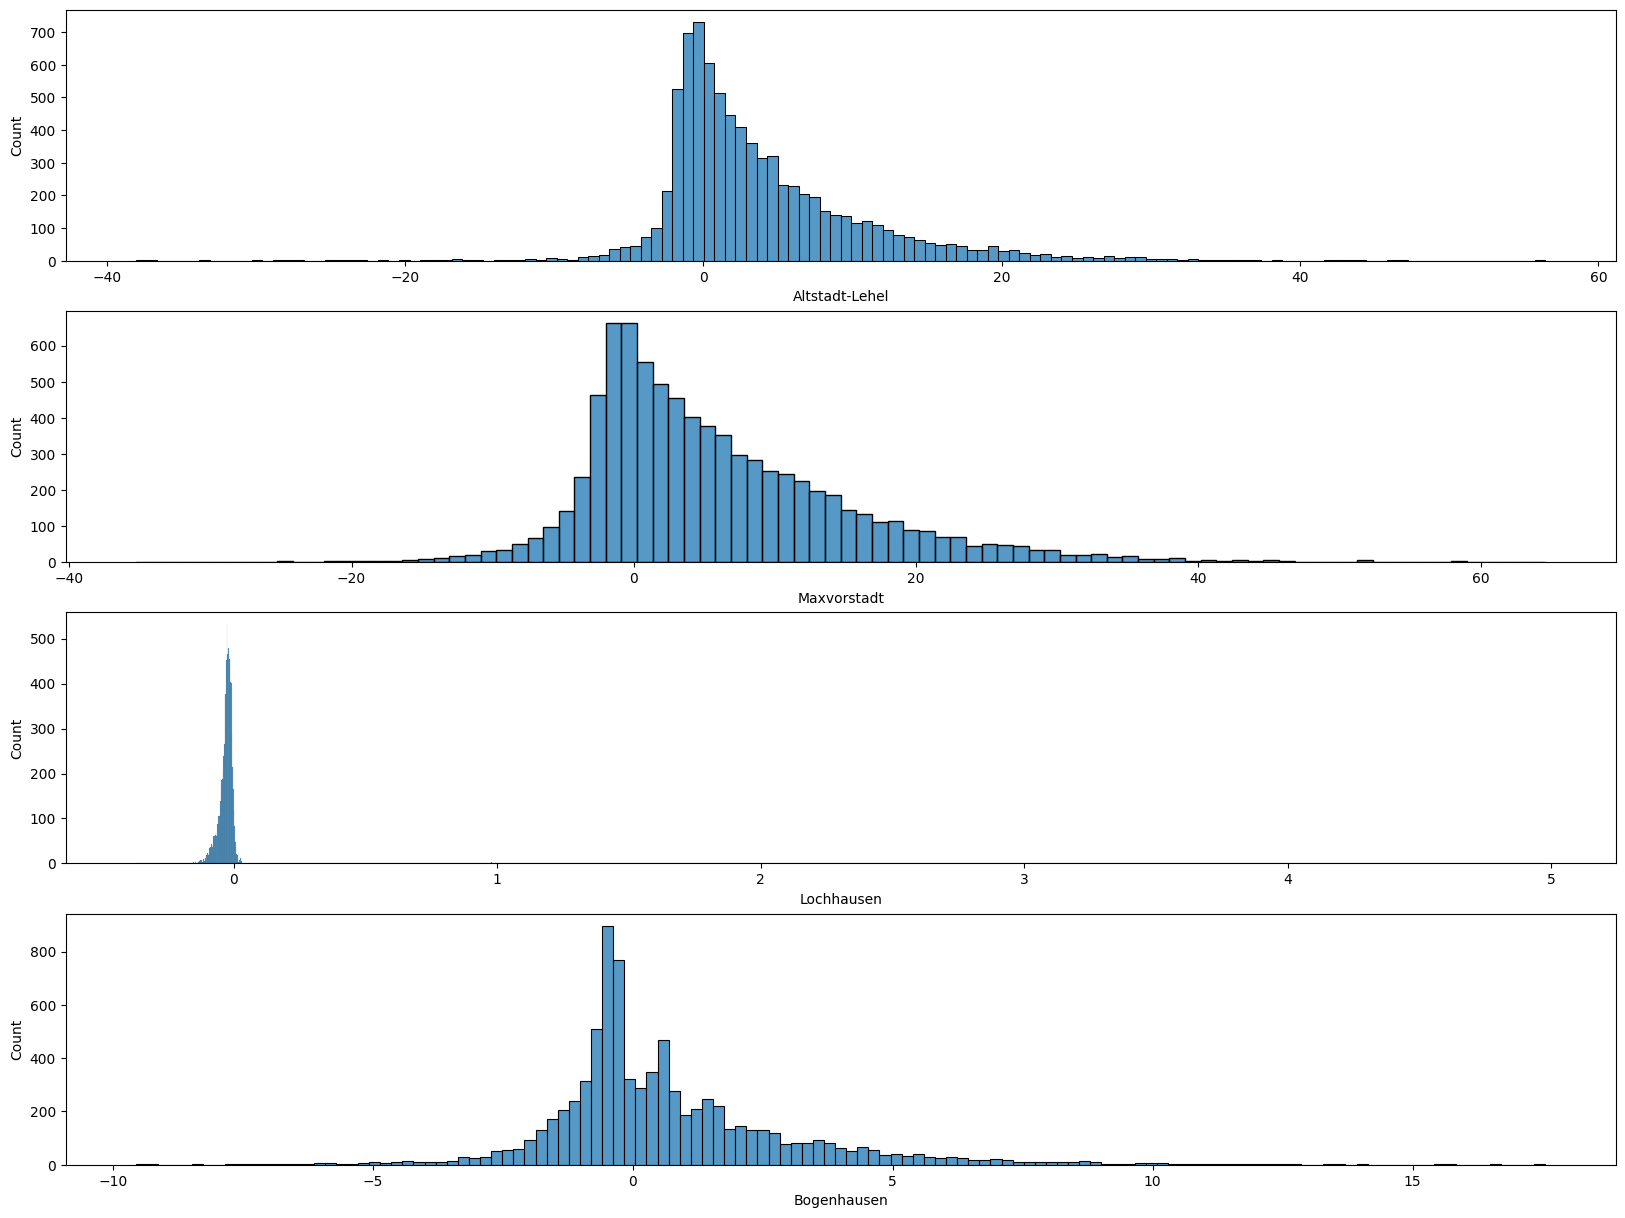

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(20,15))
for i in range(4):
  residuals = y_true_total[[districts[i]]] - y_pred_total[[districts[i]]]
  sns.histplot(x=districts[i], data=residuals, ax=ax[i])
  #sns.lineplot(x=residuals.index, y=0, data=residuals, ax=ax[i], color='red');